## Calibration

Calibrates a series of experiments in a 'master folder'

### General parameters

In [1]:
path = 'Data'

calib = dict(
    theta = 5.10,             # Transducer angle, in degrees
    t_stator = 37.89 * 1e-6,  # Time at which the US enter the geometry (the fluid)
    true_gap = 2.00 * 1e-3,      # True (corrected) gap
    c0 = 1500,                # Sound velocity in the calibration medium
    r_ext = 25 * 1e-3,        # Outer (stator) radius, in mm
    r_int = 23 * 1e-3,        # Inner (rotor) radius, in mm
)

### Imports, finding folders

In [2]:
import os
import json
import numpy as np
from functions import calibrate_one

subfolders = list(os.walk(path))[0][1]
gpt_fun = lambda fold: float(fold.split('_')[1])
subfolders = sorted(subfolders, key=gpt_fun)
subfolders = [path + '/' + sf for sf in subfolders]
gpts = [gpt_fun(sf) for sf in subfolders]

print(f'Found in `{path}`')
for no, sf in enumerate(subfolders): print(f'{no:3d} : {sf}')

Found in `Data`
  0 : Data/gpt_5
  1 : Data/gpt_10
  2 : Data/gpt_15
  3 : Data/gpt_20


### Calibration _per se_

There is a factor 1/2 in the velocity determination, present at two places : 

```python
    ax.plot(r_true/calib['true_gap'], 
            v_profile / v_max / 2, ...)
```

and

```python
    lines[no].set_ydata(v_profile / 2 / v_max)       
```

This factor was also present in Sébastien / Vincent / Thomas's code. I do not think this factor should be there, but for the sake of continuity I am keeping it.

/home/service/Documents/Brice/USV/functions.py:441: RuntimeWarning: Mean of empty slice
  v_mf = np.nanmean(velocity, axis=1)
/home/service/Documents/Brice/USV/functions.py:442: RuntimeWarning: Mean of empty slice
  v_profile = np.nanmean(v_mf, axis=0)
/home/service/Documents/pycuda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


interactive(children=(FloatSlider(value=5.1, description='theta_deg', max=6.6, min=3.5999999999999996, step=0.…

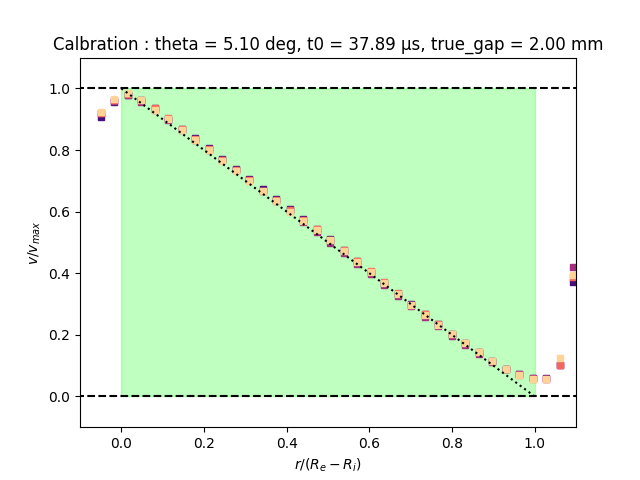

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ipywidgets import interact


%matplotlib widget

fig, ax = plt.subplots()
cm = cm.magma
cval = np.array(gpts)/max(gpts)/1.1
lines = []

# Run the routine once with "default" values, initialize line objects + static plots
for no, sf in enumerate(subfolders):
    with open(sf + '/config_calcul.json') as myfile:
        config = json.load(myfile)
    r_true, _, _, v_profile, _ = calibrate_one(calib, config, folder=sf)
    v_max = gpts[no] * calib['true_gap']
    ln, = ax.plot(r_true/calib['true_gap'], 
                  v_profile / v_max / 2, # NOTE : see markdown above
                  linestyle='', color=cm(cval[no]),
                  linewidth=0.5, marker='s', markersize=4)
    lines.append(ln)

rect = Rectangle(xy=(1-calib['true_gap']/(calib['r_ext']-calib['r_int']),0), 
                 width=calib['true_gap']/(calib['r_ext']-calib['r_int']), 
                 height=1, 
                 color='lime', 
                 alpha=0.25)

lref, = ax.plot([0,1],[1,0], 'k:')
ax.add_patch(rect)
tit = ax.set_title(f'Calbration : theta = {calib["theta"]:.2f} deg, t0 = {calib["t_stator"]*1e6} µs, true_gap = {calib["true_gap"]*1e3} mm')

# Figure formatting
ax.plot([-0.5, 1.5], [0, 0], 'k--')
ax.plot([-0.5, 1.5], [1, 1], 'k--')
ax.axis((-0.1, 1.1, -0.1, 1.1))
ax.set_xlabel('$r / (R_e - R_i)$')
ax.set_ylabel('$v / v_{max}$')

# Update function to be called by the widget
def update(theta_deg, t_stator_us, c0, true_gap_mm):
    calib['theta'] = theta_deg
    calib['t_stator'] = t_stator_us * 1e-6
    calib['c0'] = c0
    calib['true_gap'] = true_gap_mm * 1e-3
    

    rect.set_width(calib['true_gap']/(calib['r_ext']-calib['r_int']))
    rect.set_xy((1-calib['true_gap']/(calib['r_ext']-calib['r_int']),0))
    lref.set_xdata((1-calib['true_gap']/(calib['r_ext']-calib['r_int']),1))
    tit.set_text(f'Calbration : theta = {theta_deg:.2f} deg, t0 = {t_stator_us:.2f} µs, true_gap = {true_gap_mm:.2f} mm')

    for no, sf in enumerate(subfolders):
        with open(sf + '/config_calcul.json') as myfile:
            config = json.load(myfile)
        r_true, _, _, v_profile, _ = calibrate_one(calib, config, folder=sf)
        v_max = gpts[no] * (calib['r_ext'] - calib['r_int'])
        lines[no].set_xdata(r_true / (calib['r_ext'] - calib['r_int']))
        lines[no].set_ydata(v_profile / 2 / v_max) # NOTE : see markdown above

# Interactive widget
widget = interact(update, 
         theta_deg=(calib['theta']-1.5,
                    calib['theta']+1.5,0.025), 
         c0=(calib['c0']-200,
             calib['c0']+205,5), 
         t_stator_us=(calib['t_stator']*1e6-0.5,
                      calib['t_stator']*1e6+0.51,0.01), 
         true_gap_mm=(calib['true_gap']*1e3-0.10,
                      calib['true_gap']*1e3+0.101,0.01));

### Saving the calibration

In [8]:
# Gathering info from widgets
sliders = widget.widget.children
calib['theta'] = sliders[0].value
calib['t_stator'] = sliders[1].value * 1e-6
calib['c'] = sliders[2].value
calib['true_gap'] = sliders[3].value * 1e-3
calib['r_true'] = r_true.tolist()

# Saving calibration
with open(path + '/gpt_val.json', 'w') as myfile:
    print(f'Saving `gpt_val.json` in folder {os.path.abspath(path)}')
    json.dump(calib, myfile)

Saving `gpt_val.json` in folder /home/service/Documents/Brice/USV/Data
